## Stitching de las imagenes

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import itertools
import os

In [2]:
# Rutas de las imágenes
rutas_imagenes = [archivo for archivo in os.listdir() if archivo.endswith(".tif") and archivo.startswith("BJZ5-B1-4-BDA-")]

Tenemos los ficheros un array por tanto le hacemos un poco de processing donde extraeremos la capa roja que es la mas significativa, le haremos un blur para ver la forma donde las imagenes se parecen y por ultimo haremos un binarizacion para observar mas detalladamente los contornos.

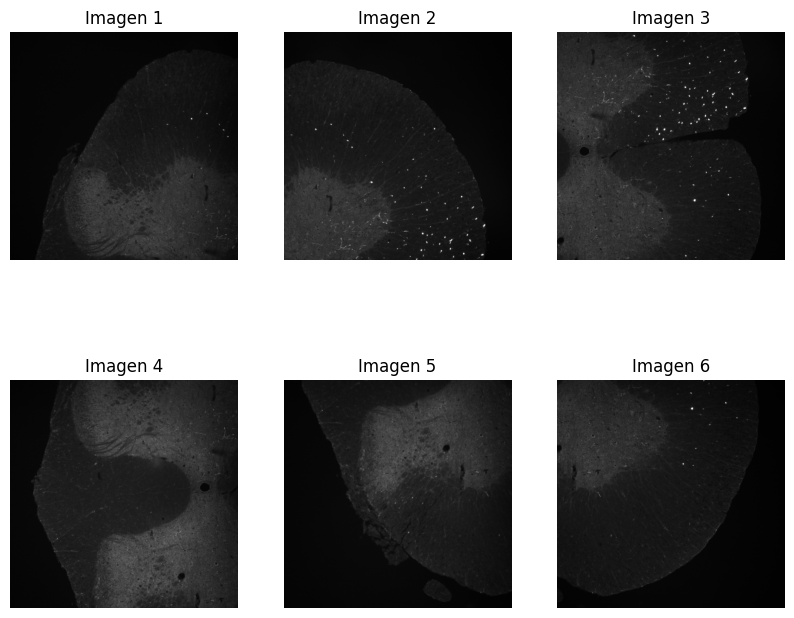

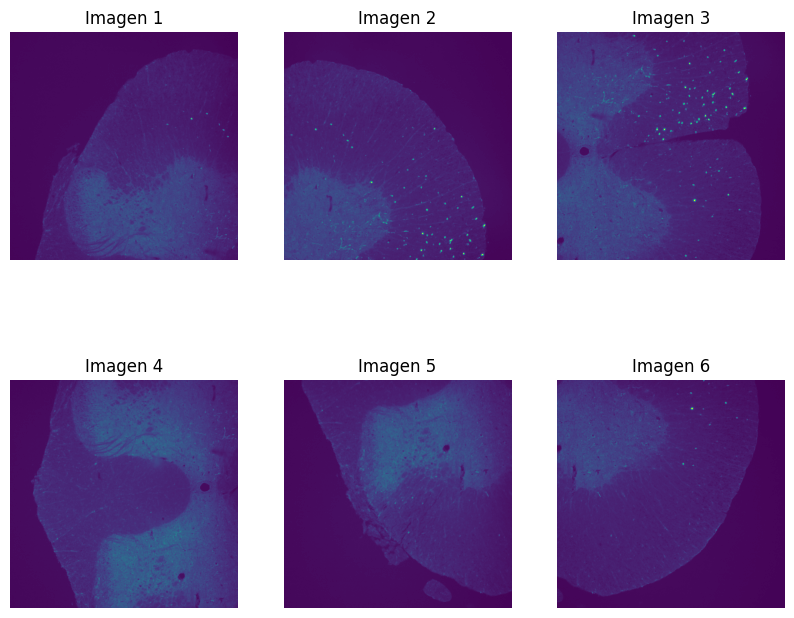

In [3]:
carpeta_guardado_cv2 = "imgs_processed"
os.makedirs(carpeta_guardado_cv2, exist_ok=True)

carpeta_guardado_plt = "imgs_red_processed"
os.makedirs(carpeta_guardado_plt, exist_ok=True)

imagenes_procesadas = []

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.subplots_adjust(hspace=0.3)

for i, ax in enumerate(axes.flatten()):
    imagen = cv2.imread(rutas_imagenes[i])
    canal_rojo = imagen[:, :, 2]
    imagenes_procesadas.append(canal_rojo)
    ax.imshow(canal_rojo, cmap='gray')
    ax.set_title(f'Imagen {i+1}')
    ax.axis('off')
    nombre_archivo_cv2 = os.path.join(carpeta_guardado_cv2, f'processed_p{i+1}.jpg')
    cv2.imwrite(nombre_archivo_cv2, canal_rojo)
    nombre_archivo_plt = os.path.join(carpeta_guardado_plt, f'plt_processed_p{i+1}.jpg')
    plt.imsave(nombre_archivo_plt, canal_rojo)

fig2, axes2 = plt.subplots(2, 3, figsize=(10, 8))
fig2.subplots_adjust(hspace=0.3)

for i, ax in enumerate(axes2.flatten()):
    imagen = cv2.imread(rutas_imagenes[i])
    canal_rojo = imagen[:, :, 2]
    ax.imshow(canal_rojo)
    ax.set_title(f'Imagen {i+1}')
    ax.axis('off')

plt.show()


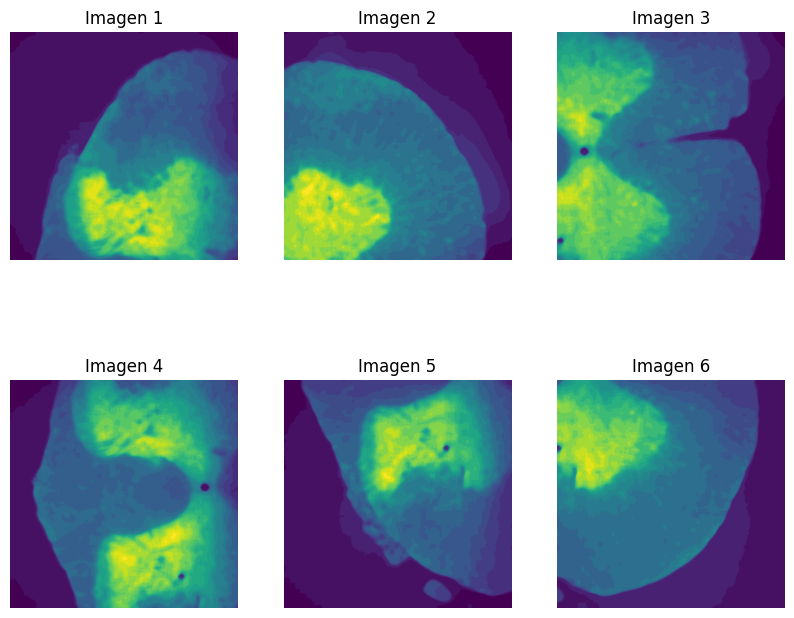

In [4]:
carpeta_guardado = "imgs_blurred"
os.makedirs(carpeta_guardado, exist_ok=True)

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.subplots_adjust(hspace=0.3)

imagenes_procesadas = []

for i, ruta_imagen in enumerate(rutas_imagenes):
    imagen = cv2.imread(ruta_imagen)
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    blurred = cv2.medianBlur(gray, 65)
    imagenes_procesadas.append(blurred)
    ax = axes[i // 3, i % 3]
    ax.imshow(blurred)
    ax.set_title(f'Imagen {i+1}')
    ax.axis('off')
    nombre_archivo = f'blurred{i+1}.jpg'
    ruta_archivo = os.path.join(carpeta_guardado, nombre_archivo)
    plt.imsave(ruta_archivo, blurred)

plt.show()

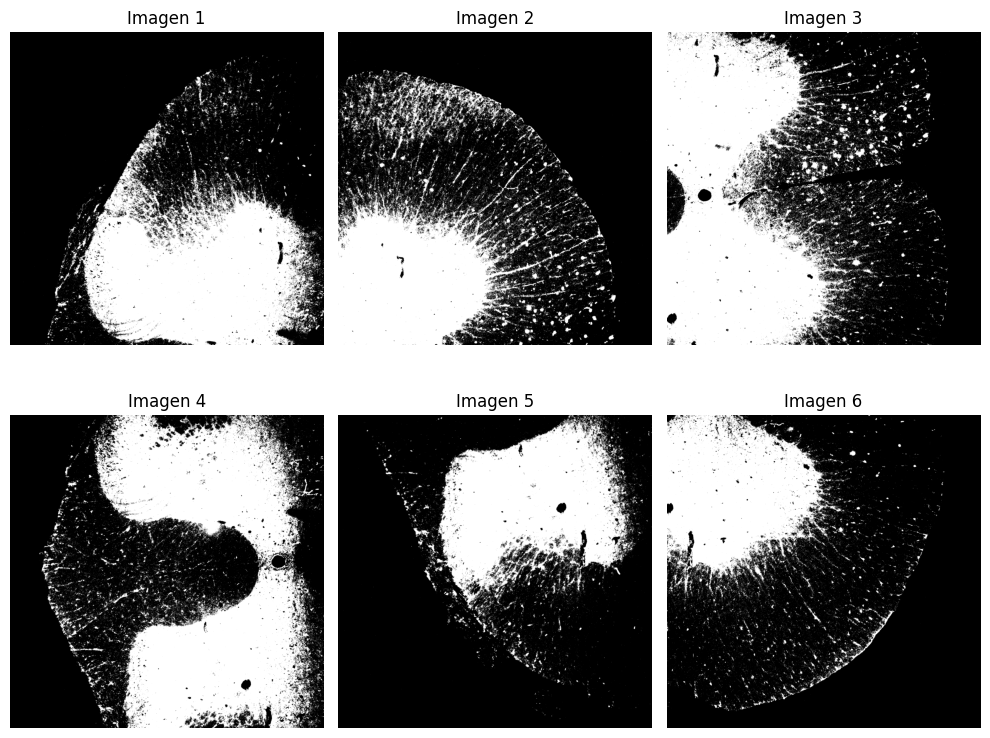

In [5]:
carpeta_guardado = "imgs_binarized"
os.makedirs(carpeta_guardado, exist_ok=True)

grayscale_images = []

fig, axes = plt.subplots(2, 3, figsize=(10, 8))
fig.subplots_adjust(hspace=0.3)

for i, ruta_imagen in enumerate(rutas_imagenes):
    imagen = cv2.imread(ruta_imagen)
    grayscale_image = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    _, threshold_image = cv2.threshold(grayscale_image, 10, 255, cv2.THRESH_BINARY)
    grayscale_images.append(threshold_image)
    ax = axes[i // 3, i % 3]
    ax.imshow(threshold_image, cmap='gray')
    ax.set_title(f'Imagen {i+1}')
    ax.axis('off')
    nombre_archivo = f'binarized_{i+1}.jpg'
    ruta_archivo = os.path.join(carpeta_guardado, nombre_archivo)
    cv2.imwrite(ruta_archivo, threshold_image)

plt.tight_layout()
plt.show()


Haremos un sift de la imagen sin modificar para ver los keypoints, no mostraremos las demas ya que el algoritmo stitch de la libreria cv2 lo hace un interno.

In [6]:
combinations = [
    (1, 2), (1, 3), (1, 4), (1, 5),
    (2, 3), (2, 4), (2, 6), (3, 4),
    (3, 5), (3, 6), (4, 5), (5, 6)
]

In [7]:
sift = cv2.SIFT_create()

image_files = [file for file in os.listdir() if file.lower().endswith('.tif')]

keypoints_list = []
descriptors_list = []

for image_file in image_files:
    img = cv2.imread(image_file, 0)
    kp, des = sift.detectAndCompute(img, None)
    keypoints_list.append(kp)
    descriptors_list.append(des)

bf = cv2.BFMatcher()

matches_list = []
for comb in combinations:
    matches = bf.match(descriptors_list[comb[0] - 1], descriptors_list[comb[1] - 1])
    matches = sorted(matches, key=lambda val: val.distance)
    matches_list.append(matches[:50])

output_folder = 'sift_normal'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for i, comb in enumerate(combinations):
    img1 = cv2.imread(image_files[comb[0] - 1], 0)
    img2 = cv2.imread(image_files[comb[1] - 1], 0)
    out = cv2.drawMatches(img1, keypoints_list[comb[0] - 1], img2, keypoints_list[comb[1] - 1], matches_list[i], None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    output_path = os.path.join(output_folder, f'sift_{comb[0]}_{comb[1]}.jpg')
    cv2.imwrite(output_path, out)


A partir de aqui probaremos un stitching entre las diferentes combinaciones que hay de las 6 imagenes y de los 4 preprocessing que hemos hecho, ya que el stitcher de cv2 saca un output diferente si cambias el orden del input que le pasas, incluso a veces con el mismo input saca dos outputs totalmente diferente.

In [8]:
folder = "imgs_processed"
imgs_processed = [archivo for archivo in os.listdir(folder) if archivo.endswith(".jpg") and archivo.startswith("processed_p")]

carpeta_resultados = "stitching_processed"
os.makedirs(carpeta_resultados, exist_ok=True)

combinaciones = list(itertools.permutations(imgs_processed, 6))

stitcher = cv2.Stitcher.create(mode=0)

num_stitchings_exitosos = 0

for i, combinacion in enumerate(combinaciones[50:100]):
    print(f"Stitching combinación {i+1} de {len(combinaciones)}: {combinacion}")
    imagenes = [cv2.imread(os.path.join(folder, ruta)) for ruta in combinacion]
    resultado, imagen_stitched = stitcher.stitch(imagenes)
    
    if resultado == cv2.Stitcher_OK:
        num_stitchings_exitosos += 1
        nombre_salida = f"stitched_{num_stitchings_exitosos}.jpg"
        ruta_salida = os.path.join(carpeta_resultados, nombre_salida)
        cv2.imwrite(ruta_salida, imagen_stitched)
        print(f"Stitching exitoso. Imagen guardada como {ruta_salida}")
    else:
        print("Stitching fallido")


Stitching combinación 1 de 720: ('processed_p1.jpg', 'processed_p4.jpg', 'processed_p2.jpg', 'processed_p5.jpg', 'processed_p3.jpg', 'processed_p6.jpg')
Stitching exitoso. Imagen guardada como stitching_processed\stitched_1.jpg
Stitching combinación 2 de 720: ('processed_p1.jpg', 'processed_p4.jpg', 'processed_p2.jpg', 'processed_p5.jpg', 'processed_p6.jpg', 'processed_p3.jpg')
Stitching exitoso. Imagen guardada como stitching_processed\stitched_2.jpg
Stitching combinación 3 de 720: ('processed_p1.jpg', 'processed_p4.jpg', 'processed_p2.jpg', 'processed_p6.jpg', 'processed_p3.jpg', 'processed_p5.jpg')
Stitching exitoso. Imagen guardada como stitching_processed\stitched_3.jpg
Stitching combinación 4 de 720: ('processed_p1.jpg', 'processed_p4.jpg', 'processed_p2.jpg', 'processed_p6.jpg', 'processed_p5.jpg', 'processed_p3.jpg')
Stitching exitoso. Imagen guardada como stitching_processed\stitched_4.jpg
Stitching combinación 5 de 720: ('processed_p1.jpg', 'processed_p4.jpg', 'processed_p3.j

In [9]:
folder = "imgs_binarized"
imgs_processed = [archivo for archivo in os.listdir(folder) if archivo.endswith(".jpg") and archivo.startswith("binarized")]

carpeta_resultados = "stitching_binarized"
os.makedirs(carpeta_resultados, exist_ok=True)

combinaciones = list(itertools.permutations(imgs_processed, 6))

stitcher = cv2.Stitcher.create(mode=0)

num_stitchings_exitosos = 0

for i, combinacion in enumerate(combinaciones[50:100]):
    print(f"Stitching combinación {i+1} de {len(combinaciones)}: {combinacion}")
    imagenes = [cv2.imread(os.path.join(folder, ruta)) for ruta in combinacion]
    resultado, imagen_stitched = stitcher.stitch(imagenes)
    
    if resultado == cv2.Stitcher_OK:
        num_stitchings_exitosos += 1
        nombre_salida = f"stitched_{num_stitchings_exitosos}.jpg"
        ruta_salida = os.path.join(carpeta_resultados, nombre_salida)
        cv2.imwrite(ruta_salida, imagen_stitched)
        print(f"Stitching exitoso. Imagen guardada como {ruta_salida}")
    else:
        print("Stitching fallido")


Stitching combinación 1 de 720: ('binarized_1.jpg', 'binarized_4.jpg', 'binarized_2.jpg', 'binarized_5.jpg', 'binarized_3.jpg', 'binarized_6.jpg')
Stitching fallido
Stitching combinación 2 de 720: ('binarized_1.jpg', 'binarized_4.jpg', 'binarized_2.jpg', 'binarized_5.jpg', 'binarized_6.jpg', 'binarized_3.jpg')
Stitching fallido
Stitching combinación 3 de 720: ('binarized_1.jpg', 'binarized_4.jpg', 'binarized_2.jpg', 'binarized_6.jpg', 'binarized_3.jpg', 'binarized_5.jpg')
Stitching fallido
Stitching combinación 4 de 720: ('binarized_1.jpg', 'binarized_4.jpg', 'binarized_2.jpg', 'binarized_6.jpg', 'binarized_5.jpg', 'binarized_3.jpg')
Stitching fallido
Stitching combinación 5 de 720: ('binarized_1.jpg', 'binarized_4.jpg', 'binarized_3.jpg', 'binarized_2.jpg', 'binarized_5.jpg', 'binarized_6.jpg')
Stitching fallido
Stitching combinación 6 de 720: ('binarized_1.jpg', 'binarized_4.jpg', 'binarized_3.jpg', 'binarized_2.jpg', 'binarized_6.jpg', 'binarized_5.jpg')
Stitching fallido
Stitching 

In [10]:
folder = "imgs_red_processed"
imgs_processed = [archivo for archivo in os.listdir(folder) if archivo.endswith(".jpg") and archivo.startswith("plt_processed_p")]

carpeta_resultados = "stitching_red_processed"
os.makedirs(carpeta_resultados, exist_ok=True)

combinaciones = list(itertools.permutations(imgs_processed, 6))

stitcher = cv2.Stitcher.create(mode=0)

num_stitchings_exitosos = 0

for i, combinacion in enumerate(combinaciones[50:100]):
    print(f"Stitching combinación {i+1} de {len(combinaciones)}: {combinacion}")
    imagenes = [cv2.imread(os.path.join(folder, ruta)) for ruta in combinacion]
    resultado, imagen_stitched = stitcher.stitch(imagenes)
    
    if resultado == cv2.Stitcher_OK:
        num_stitchings_exitosos += 1
        nombre_salida = f"stitched_{num_stitchings_exitosos}.jpg"
        ruta_salida = os.path.join(carpeta_resultados, nombre_salida)
        cv2.imwrite(ruta_salida, imagen_stitched)
        print(f"Stitching exitoso. Imagen guardada como {ruta_salida}")
    else:
        print("Stitching fallido")


Stitching combinación 1 de 720: ('plt_processed_p1.jpg', 'plt_processed_p4.jpg', 'plt_processed_p2.jpg', 'plt_processed_p5.jpg', 'plt_processed_p3.jpg', 'plt_processed_p6.jpg')
Stitching exitoso. Imagen guardada como stitching_red_processed\stitched_1.jpg
Stitching combinación 2 de 720: ('plt_processed_p1.jpg', 'plt_processed_p4.jpg', 'plt_processed_p2.jpg', 'plt_processed_p5.jpg', 'plt_processed_p6.jpg', 'plt_processed_p3.jpg')
Stitching exitoso. Imagen guardada como stitching_red_processed\stitched_2.jpg
Stitching combinación 3 de 720: ('plt_processed_p1.jpg', 'plt_processed_p4.jpg', 'plt_processed_p2.jpg', 'plt_processed_p6.jpg', 'plt_processed_p3.jpg', 'plt_processed_p5.jpg')
Stitching exitoso. Imagen guardada como stitching_red_processed\stitched_3.jpg
Stitching combinación 4 de 720: ('plt_processed_p1.jpg', 'plt_processed_p4.jpg', 'plt_processed_p2.jpg', 'plt_processed_p6.jpg', 'plt_processed_p5.jpg', 'plt_processed_p3.jpg')
Stitching exitoso. Imagen guardada como stitching_red_p

In [13]:
imgs_processed = [archivo for archivo in os.listdir()if archivo.endswith(".tif") and archivo.startswith("BJZ5-B1-4-BDA-")]

carpeta_resultados = "stitching_normal"
os.makedirs(carpeta_resultados, exist_ok=True)

combinaciones = list(itertools.permutations(imgs_processed, 6))

stitcher = cv2.Stitcher.create(mode=0)

num_stitchings_exitosos = 0

for i, combinacion in enumerate(combinaciones[50:100]):
    print(f"Stitching combinación {i+1} de {len(combinaciones)}: {combinacion}")
    
    imagenes = [cv2.imread(ruta) for ruta in combinacion]
    
    resultado, imagen_stitched = stitcher.stitch(imagenes)
    
    if resultado == cv2.Stitcher_OK:
        num_stitchings_exitosos += 1
        
        nombre_salida = f"stitched_{num_stitchings_exitosos}.jpg"
        ruta_salida = os.path.join(carpeta_resultados, nombre_salida)
        
        cv2.imwrite(ruta_salida, imagen_stitched)
        print(f"Stitching exitoso. Imagen guardada como {ruta_salida}")
    else:
        print("Stitching fallido")



Stitching combinación 1 de 720: ('BJZ5-B1-4-BDA-1.tif', 'BJZ5-B1-4-BDA-4.tif', 'BJZ5-B1-4-BDA-2.tif', 'BJZ5-B1-4-BDA-5.tif', 'BJZ5-B1-4-BDA-3.tif', 'BJZ5-B1-4-BDA-6.tif')
Stitching exitoso. Imagen guardada como stitching_normal\stitched_1.jpg
Stitching combinación 2 de 720: ('BJZ5-B1-4-BDA-1.tif', 'BJZ5-B1-4-BDA-4.tif', 'BJZ5-B1-4-BDA-2.tif', 'BJZ5-B1-4-BDA-5.tif', 'BJZ5-B1-4-BDA-6.tif', 'BJZ5-B1-4-BDA-3.tif')
Stitching exitoso. Imagen guardada como stitching_normal\stitched_2.jpg
Stitching combinación 3 de 720: ('BJZ5-B1-4-BDA-1.tif', 'BJZ5-B1-4-BDA-4.tif', 'BJZ5-B1-4-BDA-2.tif', 'BJZ5-B1-4-BDA-6.tif', 'BJZ5-B1-4-BDA-3.tif', 'BJZ5-B1-4-BDA-5.tif')
Stitching exitoso. Imagen guardada como stitching_normal\stitched_3.jpg
Stitching combinación 4 de 720: ('BJZ5-B1-4-BDA-1.tif', 'BJZ5-B1-4-BDA-4.tif', 'BJZ5-B1-4-BDA-2.tif', 'BJZ5-B1-4-BDA-6.tif', 'BJZ5-B1-4-BDA-5.tif', 'BJZ5-B1-4-BDA-3.tif')
Stitching exitoso. Imagen guardada como stitching_normal\stitched_4.jpg
Stitching combinación 5 de 7